# Final Project Submission
Please fill out:

-  Student name: Steven Rosa
-  Student pace: part time
-  Scheduled project review date/time: Mon 4 Feb 2019 2pm EST
-  Instructor name: Jeff Herman
-  Blog post URL:

# Northwind Data Analysis

<a id="top"></a>

# Contents
- [Import libraries](#importlibraries)
- [Write functions](#writefunctions)
- [Exploratory data analysis](#eda)
- [Hypothesis test 1](#hypo1): Products ordered with and without discounts
- [Hypothesis test 2](#hypo2): Sales by London office versus PNW offices
- [Hypothesis test 3](#hypo3)
- [Hypothesis test 4](#hypo4)

<a id="importlibraries"></a>

# Import libraries
[(Back to top)](#top)

In [1]:
#Import libraries
import sqlalchemy #ORM
from sqlalchemy import create_engine #To connect to the database
from sqlalchemy.orm import Session, sessionmaker #To interact with the database as object
from sqlalchemy import inspect #To look at tables and column names
from sqlalchemy import MetaData #To reflect the engine object 
from sqlalchemy.ext.automap import automap_base # To create mappings from the reflection
import pandas as pd #To read in parts of the database as DataFrames
import matplotlib.pyplot as plt #For creating visualizations
%matplotlib inline
from scipy import stats #For pulling t values
from scipy.stats import norm #For plotting probablity density functions
import seaborn as sns #For plotting pdfs over histograms
import numpy as np #For mathematical operations and arrays
from sklearn.utils import resample #To pull samples from a small distribution (bootstrapping)

<a id="writefunctions"></a>

# Write functions
[(Back to top)](#top)

In [2]:
#Build a sampling distribution of the data 
#in order to get it more "normal"
#NOT IN USE, REPLACED BY BOOTSTRAPPING
def sampling_dist(data, dist=50, n=30):

    sample_dist = []
   
    while len(sample_dist) != dist: #Build a sample distribution
        sample = []
        while len(sample) != n:
            x = np.random.choice(data) #Get a value from the data with replacement
            sample.append(x) #Add the value to the sample
        sample_mean = sum(sample) / len(sample) #Get the mean of the sample
        sample_dist.append(sample_mean) #Add the mean to the sampling distribution
    
    return sample_dist

<a id="eda"></a>

# Exploratory data analysis
[(Back to top)](#top)

In [4]:
#Instantiate a session of the ORM
#Connect to the sqlite database file
engine = create_engine('sqlite:///Northwind_small.sqlite', echo = True)
#Bind a session factory to the engine
Session = sessionmaker(bind=engine)
#Instantiate a session
session = Session()

In [5]:
#An object to get a first look at the database
inspector = inspect(engine)

2019-02-01 20:19:08,960 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-02-01 20:19:08,960 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:08,960 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-02-01 20:19:08,960 INFO sqlalchemy.engine.base.Engine ()


In [6]:
#Make a dict of list of names of all the columns in all the tables
#for easy reference

#Get list of all table names
table_names = inspector.get_table_names()

tables_columns = dict()
#For each table name
for table in table_names:
    column_names = []
    #for each column in the table, get just the name
    for column in inspector.get_columns(table):
        column_names.append(column['name'])
    tables_columns[table] = column_names

2019-02-01 20:19:10,718 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-02-01 20:19:10,718 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerDemographic")
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-02-01 20:19:10,733 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:10,749 INFO sqlalche

In [8]:
#######################################
#AUTOMAPPER BITS
#Instantiate metadata to reflect the engine
metadata = MetaData()

metadata.reflect(engine)

#Create mappings to treat the database elements as OOP objects
Base = automap_base(metadata=metadata)
Base.prepare()

2019-02-01 20:19:56,458 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-02-01 20:19:56,459 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,461 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-02-01 20:19:56,462 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,464 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-02-01 20:19:56,464 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,466 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Category")
2019-02-01 20:19:56,467 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,468 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-02-01 20:19:56,470 INFO sqlalchemy.engine.base.Engin

2019-02-01 20:19:56,539 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("EmployeeTerritory")
2019-02-01 20:19:56,540 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,540 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'EmployeeTerritory' AND type = 'table'
2019-02-01 20:19:56,541 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,542 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("EmployeeTerritory")
2019-02-01 20:19:56,543 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,544 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("EmployeeTerritory")
2019-02-01 20:19:56,545 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,546 INFO sqlalchemy.engine.base.Engine PRAGMA index_info("sqlite_autoindex_EmployeeTerritory_1")
2019-02-01 20:19:56,547 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,548 INFO sqlalchemy.engine.base.Engine SELECT sql 

2019-02-01 20:19:56,614 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Supplier")
2019-02-01 20:19:56,616 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,619 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Supplier' AND type = 'table'
2019-02-01 20:19:56,625 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,627 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Supplier")
2019-02-01 20:19:56,628 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,637 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Supplier' AND type = 'table'
2019-02-01 20:19:56,638 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,640 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("Supplier")
2019-02-01 20:19:56,640 INFO sqlalchemy.engine.base.Engine ()
2019-02-01 20:19:56,641 INFO 

In [9]:
#Create an object for each table
Category = Base.classes.Category
Customer = Base.classes.Customer
CustomerCustomerDemo = Base.classes.CustomerCustomerDemo
CustomerDemographic = Base.classes.CustomerDemographic
Employee = Base.classes.Employee
EmployeeTerritory = Base.classes.EmployeeTerritory
Order = Base.classes.Order
OrderDetail = Base.classes.OrderDetail
Product = Base.classes.Product
Region = Base.classes.Region
Shipper = Base.classes.Shipper
Supplier = Base.classes.Supplier
Territory = Base.classes.Territory

In [10]:
#What does the company sell?
#Look at descriptions of categories for items sold
for instance in session.query(Category):
    print(instance.CategoryName, ":", instance.Description)

2019-02-01 20:20:03,279 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2019-02-01 20:20:03,281 INFO sqlalchemy.engine.base.Engine SELECT "Category"."Id" AS "Category_Id", "Category"."CategoryName" AS "Category_CategoryName", "Category"."Description" AS "Category_Description" 
FROM "Category"
2019-02-01 20:20:03,281 INFO sqlalchemy.engine.base.Engine ()
Beverages : Soft drinks, coffees, teas, beers, and ales
Condiments : Sweet and savory sauces, relishes, spreads, and seasonings
Confections : Desserts, candies, and sweet breads
Dairy Products : Cheeses
Grains/Cereals : Breads, crackers, pasta, and cereal
Meat/Poultry : Prepared meats
Produce : Dried fruit and bean curd
Seafood : Seaweed and fish


In [11]:
#How many customers ae served?
names = []
for instance in session.query(Customer):
    names.append(instance.ContactName)

print('\n')
print(len(set(names)), 'customers served.')

2019-02-01 20:20:07,794 INFO sqlalchemy.engine.base.Engine SELECT "Customer"."Id" AS "Customer_Id", "Customer"."CompanyName" AS "Customer_CompanyName", "Customer"."ContactName" AS "Customer_ContactName", "Customer"."ContactTitle" AS "Customer_ContactTitle", "Customer"."Address" AS "Customer_Address", "Customer"."City" AS "Customer_City", "Customer"."Region" AS "Customer_Region", "Customer"."PostalCode" AS "Customer_PostalCode", "Customer"."Country" AS "Customer_Country", "Customer"."Phone" AS "Customer_Phone", "Customer"."Fax" AS "Customer_Fax" 
FROM "Customer"
2019-02-01 20:20:07,795 INFO sqlalchemy.engine.base.Engine ()


91 customers served.


In [12]:
#How many customers are served in each region?
regions = []
for instance in session.query(Customer):
    regions.append(instance.Region)

regions_df = pd.DataFrame(regions)
regions_df[0].value_counts()

2019-02-01 20:20:10,738 INFO sqlalchemy.engine.base.Engine SELECT "Customer"."Id" AS "Customer_Id", "Customer"."CompanyName" AS "Customer_CompanyName", "Customer"."ContactName" AS "Customer_ContactName", "Customer"."ContactTitle" AS "Customer_ContactTitle", "Customer"."Address" AS "Customer_Address", "Customer"."City" AS "Customer_City", "Customer"."Region" AS "Customer_Region", "Customer"."PostalCode" AS "Customer_PostalCode", "Customer"."Country" AS "Customer_Country", "Customer"."Phone" AS "Customer_Phone", "Customer"."Fax" AS "Customer_Fax" 
FROM "Customer"
2019-02-01 20:20:10,739 INFO sqlalchemy.engine.base.Engine ()


Western Europe     28
North America      16
South America      16
Southern Europe    10
British Isles       8
Central America     5
Northern Europe     4
Scandinavia         3
Eastern Europe      1
Name: 0, dtype: int64

In [198]:
#How many products are in each category?
#Some products have been discontinued. Must exclude these from query
prod_cats = pd.read_sql_query('''SELECT ca.Id, ca.CategoryName,
                                COUNT(p.ProductName) Products
                                FROM Product p
                                JOIN Category ca ON p.CategoryId = ca.Id
                                WHERE p.Discontinued = 0
                                GROUP BY ca.Id
                            ''', engine)
prod_cats

2019-02-01 17:42:32,485 INFO sqlalchemy.engine.base.Engine SELECT ca.Id, ca.CategoryName,
                                COUNT(p.ProductName) Products
                                FROM Product p
                                JOIN Category ca ON p.CategoryId = ca.Id
                                WHERE p.Discontinued = 0
                                GROUP BY ca.Id
                            


INFO:sqlalchemy.engine.base.Engine:SELECT ca.Id, ca.CategoryName,
                                COUNT(p.ProductName) Products
                                FROM Product p
                                JOIN Category ca ON p.CategoryId = ca.Id
                                WHERE p.Discontinued = 0
                                GROUP BY ca.Id
                            


2019-02-01 17:42:32,487 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Id,CategoryName,Products
0,1,Beverages,11
1,2,Condiments,11
2,3,Confections,13
3,4,Dairy Products,10
4,5,Grains/Cereals,6
5,6,Meat/Poultry,2
6,7,Produce,4
7,8,Seafood,12


In [ ]:
#How much revenue is earned from each category?

In [202]:
prod_cats['Products'].sum()

69

In [199]:
#Checking out all products
products = pd.read_sql_query('''SELECT p.*
                                FROM Product p
                                WHERE p.Discontinued != 1
                            ''', engine)
#products

2019-02-01 17:46:28,554 INFO sqlalchemy.engine.base.Engine SELECT p.*
                                FROM Product p
                                WHERE p.Discontinued != 1
                            


INFO:sqlalchemy.engine.base.Engine:SELECT p.*
                                FROM Product p
                                WHERE p.Discontinued != 1
                            


2019-02-01 17:46:28,556 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


In [214]:
#How many products are in stock above par? 
products = pd.read_sql_query('''SELECT
                                    SUM(
                                        CASE WHEN p.UnitsInStock <= p.ReorderLevel 
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) below_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > p.ReorderLevel 
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) all_above_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > p.ReorderLevel
                                            AND p.UnitsInStock < (2 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) less_2x_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (2 * p.ReorderLevel)
                                            AND p.UnitsInStock < (3 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x2_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (3 * p.ReorderLevel)
                                            AND p.UnitsInStock < (4 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x3_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (4 * p.ReorderLevel)
                                            AND p.UnitsInStock < (5 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x4_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (5 * p.ReorderLevel)
                                            AND p.UnitsInStock < (6 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x5_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (6 * p.ReorderLevel)
                                            AND p.UnitsInStock < (7 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x6_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (7 * p.ReorderLevel)
                                            AND p.UnitsInStock < (8 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x7_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (8 * p.ReorderLevel)
                                            AND p.UnitsInStock < (9 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x8_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (9 * p.ReorderLevel)
                                            AND p.UnitsInStock < (10 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x9_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > (10 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) x10_par
                                FROM Product p
                            ''', engine)
products 

2019-02-01 18:12:56,433 INFO sqlalchemy.engine.base.Engine SELECT
                                    SUM(
                                        CASE WHEN p.UnitsInStock <= p.ReorderLevel 
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) below_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > p.ReorderLevel 
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) all_above_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > p.ReorderLevel
                                            AND p.UnitsInStock < (2 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1

INFO:sqlalchemy.engine.base.Engine:SELECT
                                    SUM(
                                        CASE WHEN p.UnitsInStock <= p.ReorderLevel 
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) below_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > p.ReorderLevel 
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
                                        ) all_above_par,
                                    SUM(
                                        CASE WHEN p.UnitsInStock > p.ReorderLevel
                                            AND p.UnitsInStock < (2 * p.ReorderLevel)
                                            AND p.Discontinued != 1
                                        THEN 1 ELSE 0 END
            

2019-02-01 18:12:56,434 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,below_par,all_above_par,less_2x_par,x2_par,x3_par,x4_par,x5_par,x6_par,x7_par,x8_par,x9_par,x10_par
0,18,51,8,7,2,6,4,0,2,1,0,18


In [ ]:
#49 products out of 69 are above par

In [13]:
overstock = pd.read_sql_query('''SELECT p.*
                                FROM Product p
                                WHERE p.UnitsInStock > (10 * p.ReorderLevel)
                                    AND p.Discontinued != 1
                                ''', engine)
overstock.head()

2019-02-01 20:22:58,464 INFO sqlalchemy.engine.base.Engine SELECT p.*
                                FROM Product p
                                WHERE p.UnitsInStock > (10 * p.ReorderLevel)
                                    AND p.Discontinued != 1
                                
2019-02-01 20:22:58,464 INFO sqlalchemy.engine.base.Engine ()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
1,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00,6,0,0,0
2,10,Ikura,4,8,12 - 200 ml jars,31.00,31,0,0,0
3,12,Queso Manchego La Pastora,5,4,10 - 500 g pkgs.,38.00,86,0,0,0
4,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0


In [188]:
tables_columns['Product']

['Id',
 'ProductName',
 'SupplierId',
 'CategoryId',
 'QuantityPerUnit',
 'UnitPrice',
 'UnitsInStock',
 'UnitsOnOrder',
 'ReorderLevel',
 'Discontinued']

In [33]:
#Look at how many territories are assigned to each employee
df = pd.read_sql_query('''SELECT e.Id, e.LastName, e.FirstName, e.Title, e.HireDate, e.City, 
                            count(et.TerritoryId) Territories
                            FROM Employee e
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            GROUP BY e.Id
                        ''', engine)
df

2019-02-01 08:29:40,062 INFO sqlalchemy.engine.base.Engine SELECT e.Id, e.LastName, e.FirstName, e.Title, e.HireDate, e.City, 
                            count(et.TerritoryId) Territories
                            FROM Employee e
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            GROUP BY e.Id
                        


INFO:sqlalchemy.engine.base.Engine:SELECT e.Id, e.LastName, e.FirstName, e.Title, e.HireDate, e.City, 
                            count(et.TerritoryId) Territories
                            FROM Employee e
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            GROUP BY e.Id
                        


2019-02-01 08:29:40,063 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Id,LastName,FirstName,Title,HireDate,City,Territories
0,1,Davolio,Nancy,Sales Representative,2024-05-01,Seattle,2
1,2,Fuller,Andrew,"Vice President, Sales",2024-08-14,Tacoma,7
2,3,Leverling,Janet,Sales Representative,2024-04-01,Kirkland,4
3,4,Peacock,Margaret,Sales Representative,2025-05-03,Redmond,3
4,5,Buchanan,Steven,Sales Manager,2025-10-17,London,7
5,6,Suyama,Michael,Sales Representative,2025-10-17,London,5
6,7,King,Robert,Sales Representative,2026-01-02,London,10
7,8,Callahan,Laura,Inside Sales Coordinator,2026-03-05,Seattle,4
8,9,Dodsworth,Anne,Sales Representative,2026-11-15,London,7


In [ ]:
#5 employees in the PNW USA and 4 in London. Each employee has several territories assigned

In [142]:
df = pd.read_sql_query('''SELECT e.Id, e.LastName, e.FirstName, e.City, e.HireDate,
                            r.RegionDescription,
                            COUNT(DISTINCT od.OrderId) Orders,
                            SUM(od.Quantity) Quantities
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            JOIN Territory t on et.Territoryid = t.Id
                            JOIN Region r on t.RegionId = r.Id
                            GROUP BY e.Id
                            ORDER BY e.HireDate
                        ''', engine)
df

2019-02-01 16:29:29,209 INFO sqlalchemy.engine.base.Engine SELECT e.Id, e.LastName, e.FirstName, e.City, e.HireDate,
                            r.RegionDescription,
                            COUNT(DISTINCT od.OrderId) Orders,
                            SUM(od.Quantity) Quantities
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            JOIN Territory t on et.Territoryid = t.Id
                            JOIN Region r on t.RegionId = r.Id
                            GROUP BY e.Id
                            ORDER BY e.HireDate
                        


INFO:sqlalchemy.engine.base.Engine:SELECT e.Id, e.LastName, e.FirstName, e.City, e.HireDate,
                            r.RegionDescription,
                            COUNT(DISTINCT od.OrderId) Orders,
                            SUM(od.Quantity) Quantities
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            JOIN Territory t on et.Territoryid = t.Id
                            JOIN Region r on t.RegionId = r.Id
                            GROUP BY e.Id
                            ORDER BY e.HireDate
                        


2019-02-01 16:29:29,211 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Id,LastName,FirstName,City,HireDate,RegionDescription,Orders,Quantities
0,3,Leverling,Janet,Kirkland,2024-04-01,Southern,127,31408
1,1,Davolio,Nancy,Seattle,2024-05-01,Eastern,123,15624
2,2,Fuller,Andrew,Tacoma,2024-08-14,Eastern,96,42385
3,4,Peacock,Margaret,Redmond,2025-05-03,Eastern,156,29394
4,5,Buchanan,Steven,London,2025-10-17,Eastern,42,21252
5,6,Suyama,Michael,London,2025-10-17,Western,67,17635
6,7,King,Robert,London,2026-01-02,Western,72,46540
7,8,Callahan,Laura,Seattle,2026-03-05,Northern,104,23652
8,9,Dodsworth,Anne,London,2026-11-15,Northern,43,18690


In [ ]:
#Earlier hire date doesn't indicate higher sales per employee

In [43]:
#Examine how often each product is sold with/without discount

product_discs = pd.read_sql_query('''SELECT p.ProductName, od.UnitPrice,
                            COUNT(od.Id) Times_ordered,
                            SUM(
                                CASE WHEN od.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) not_discounted,
                            SUM(
                                CASE WHEN od.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) discounted
                            FROM Product p
                            JOIN OrderDetail od on p.Id = od.ProductId
                            GROUP BY p.ProductName
                        ''', engine)

product_discs.head(10)

2019-02-01 21:35:14,245 INFO sqlalchemy.engine.base.Engine SELECT p.ProductName, od.UnitPrice,
                            COUNT(od.Id) Times_ordered,
                            SUM(
                                CASE WHEN od.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) not_discounted,
                            SUM(
                                CASE WHEN od.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) discounted
                            FROM Product p
                            JOIN OrderDetail od on p.Id = od.ProductId
                            GROUP BY p.ProductName
                        


INFO:sqlalchemy.engine.base.Engine:SELECT p.ProductName, od.UnitPrice,
                            COUNT(od.Id) Times_ordered,
                            SUM(
                                CASE WHEN od.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) not_discounted,
                            SUM(
                                CASE WHEN od.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) discounted
                            FROM Product p
                            JOIN OrderDetail od on p.Id = od.ProductId
                            GROUP BY p.ProductName
                        


2019-02-01 21:35:14,261 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,ProductName,UnitPrice,Times_ordered,not_discounted,discounted
0,Alice Mutton,39.00,37,21,16
1,Aniseed Syrup,10.00,12,10,2
2,Boston Crab Meat,18.40,41,25,16
3,Camembert Pierrot,34.00,51,28,23
4,Carnarvon Tigers,62.50,27,14,13
5,Chai,18.00,38,22,16
6,Chang,19.00,44,19,25
7,Chartreuse verte,18.00,30,16,14
8,Chef Anton's Cajun Seasoning,22.00,20,10,10
9,Chef Anton's Gumbo Mix,21.35,10,6,4


In [83]:
#
#
#Did more products have higher sales with or without discounts?
total_products = products_discs.shape[0]
more_without_discs = products_discs[products_discs['not_discounted'] > products_discs['discounted']]
more_with_discs = products_discs[products_discs['not_discounted'] < products_discs['discounted']]

print('Products with higher sales when not discounted:', more_without_discs.shape[0])
print('Products with higher sales when discounted:', more_with_discs.shape[0])
if more_without_discs.shape[0] > more_with_discs.shape[0]:
    print("More products had higher sales without discounts than with discounts.")

Products with higher sales when not discounted: 64
Products with higher sales when discounted: 9
More products had higher sales without discounts than with discounts.


In [47]:
#
#
#Did the products which had higher sales when discounted have a higher unit price on average?
mean_without = more_without_discs['UnitPrice'].mean()
mean_with = more_with_discs['UnitPrice'].mean()

print('Mean unit price for products which had higher sales when not discounted:',
      mean_without)
print('Mean unit price for products which had higher sales when discounted:',
     mean_with)
if mean_without > mean_with:
    print('Products with sales when discounted did not have a higher unit price on average.')

Mean unit price for products which had higher sales when not discounted: 29.53453125
Mean unit price for products which had higher sales when discounted: 26.883333333333333
Products with sales when discounted did not have a higher unit price on average.


In [80]:
#
#
#Has higher revenue been taken in on products with or without discounts?
invoices = pd.read_sql_query('''SELECT od.Id, od.OrderId, p.ProductName, od.UnitPrice, 
                            od.Quantity, od.Discount,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        ''', engine)
invoices.head(10)


2019-02-01 13:22:10,694 INFO sqlalchemy.engine.base.Engine SELECT od.Id, od.OrderId, p.ProductName, od.UnitPrice, 
                            od.Quantity, od.Discount,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        


INFO:sqlalchemy.engine.base.Engine:SELECT od.Id, od.OrderId, p.ProductName, od.UnitPrice, 
                            od.Quantity, od.Discount,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        


2019-02-01 13:22:10,695 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Id,OrderId,ProductName,UnitPrice,Quantity,Discount,Total_price
0,10248/11,10248,Queso Cabrales,14.0,12,0.00,168.00
1,10248/42,10248,Singaporean Hokkien Fried Mee,9.8,10,0.00,98.00
2,10248/72,10248,Mozzarella di Giovanni,34.8,5,0.00,174.00
3,10249/14,10249,Tofu,18.6,9,0.00,167.40
4,10249/51,10249,Manjimup Dried Apples,42.4,40,0.00,1696.00
5,10250/41,10250,Jack's New England Clam Chowder,7.7,10,0.00,77.00
6,10250/51,10250,Manjimup Dried Apples,42.4,35,0.15,1261.40
7,10250/65,10250,Louisiana Fiery Hot Pepper Sauce,16.8,15,0.15,214.20
8,10251/22,10251,Gustaf's Knäckebröd,16.8,6,0.05,95.76
9,10251/57,10251,Ravioli Angelo,15.6,15,0.05,222.30


In [81]:
#Get invoice subtotals from only items that weren't discounted
subtotals_without_disc = invoices['Total_price'][invoices['Discount'] == 0.0]
#Get invoice subttoals from only items that were discounted
subtotals_with_disc = invoices['Total_price'][invoices['Discount'] != 0.0]

#Add up subtotals for all undiscounted items
revenue_without_disc = subtotals_without_disc.sum()
#Add up subtotals for all discounted items
revenue_with_disc = subtotals_with_disc.sum()

print('Revenue from undiscounted items:', revenue_without_disc)
print('Revenue from discounted items:', revenue_with_disc)
if revenue_without_disc > revenue_with_disc:
    print('Revenue was higher from undiscounted items.')

Revenue from undiscounted items: 750698.61
Revenue from discounted items: 515094.42949999997
Revenue was higher from undiscounted items.


In [77]:
#Discrepancies in unit prices between Product table and OrderDetail table

invoices_testing = pd.read_sql_query('''SELECT od.Id, od.OrderId, p.ProductName, p.UnitPrice UnitPriceP, 
                            od.UnitPrice UnitPriceOd, od.Quantity, od.Discount,
                            ((p.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_with_P,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_withOd
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        ''', engine)
invoices_testing.head(10)

2019-02-01 12:51:13,076 INFO sqlalchemy.engine.base.Engine SELECT od.Id, od.OrderId, p.ProductName, p.UnitPrice UnitPriceP, 
                            od.UnitPrice UnitPriceOd, od.Quantity, od.Discount,
                            ((p.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_with_P,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_withOd
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        


INFO:sqlalchemy.engine.base.Engine:SELECT od.Id, od.OrderId, p.ProductName, p.UnitPrice UnitPriceP, 
                            od.UnitPrice UnitPriceOd, od.Quantity, od.Discount,
                            ((p.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_with_P,
                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Total_price_withOd
                            FROM OrderDetail od
                            JOIN Product p ON od.ProductId = p.Id
                        


2019-02-01 12:51:13,077 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Id,OrderId,ProductName,UnitPriceP,UnitPriceOd,Quantity,Discount,Total_price_with_P,Total_price_withOd
0,10248/11,10248,Queso Cabrales,21.00,14.0,12,0.00,252.0000,168.00
1,10248/42,10248,Singaporean Hokkien Fried Mee,14.00,9.8,10,0.00,140.0000,98.00
2,10248/72,10248,Mozzarella di Giovanni,34.80,34.8,5,0.00,174.0000,174.00
3,10249/14,10249,Tofu,23.25,18.6,9,0.00,209.2500,167.40
4,10249/51,10249,Manjimup Dried Apples,53.00,42.4,40,0.00,2120.0000,1696.00
5,10250/41,10250,Jack's New England Clam Chowder,9.65,7.7,10,0.00,96.5000,77.00
6,10250/51,10250,Manjimup Dried Apples,53.00,42.4,35,0.15,1576.7500,1261.40
7,10250/65,10250,Louisiana Fiery Hot Pepper Sauce,21.05,16.8,15,0.15,268.3875,214.20
8,10251/22,10251,Gustaf's Knäckebröd,21.00,16.8,6,0.05,119.7000,95.76
9,10251/57,10251,Ravioli Angelo,19.50,15.6,15,0.05,277.8750,222.30


In [79]:
#How often is the Product unit price different from the OrderDetail unit price?
different_unit_prices = invoices_testing[invoices_testing['UnitPriceP'] != invoices_testing['UnitPriceOd']]
invoices_testing.shape[0], different_unit_prices.shape[0]

(2155, 658)

In [45]:
#
#
#How many products per supplier?
prod_supp = pd.read_sql_query('''SELECT s.CompanyName, s.Region, COUNT(p.ProductName) Products
                                    FROM Product p
                                    JOIN Supplier s ON p.SupplierId = s.Id
                                    GROUP BY s.CompanyName
                                ''', engine)
prod_supp.head()

2019-02-01 21:35:33,709 INFO sqlalchemy.engine.base.Engine SELECT s.CompanyName, s.Region, COUNT(p.ProductName) Products
                                    FROM Product p
                                    JOIN Supplier s ON p.SupplierId = s.Id
                                    GROUP BY s.CompanyName
                                


INFO:sqlalchemy.engine.base.Engine:SELECT s.CompanyName, s.Region, COUNT(p.ProductName) Products
                                    FROM Product p
                                    JOIN Supplier s ON p.SupplierId = s.Id
                                    GROUP BY s.CompanyName
                                


2019-02-01 21:35:33,709 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,CompanyName,Region,Products
0,Aux joyeux ecclésiastiques,Western Europe,2
1,Bigfoot Breweries,North America,3
2,Cooperativa de Quesos 'Las Cabras',Southern Europe,2
3,Escargots Nouveaux,Western Europe,1
4,Exotic Liquids,British Isles,3


In [ ]:

#####FOR EDA
#Pull raw results from the database
#conn = engine.connect()
#results = conn.execute('''SELECT *
#                            FROM Category
#                        ;''')
#print(results.fetchall())

###conn = engine.connect()
#results = conn.execute("SELECT * FROM [Order];")
#df = pd.DataFrame(results.fetchall())
#df.head()

#results = conn.execute('''SELECT *
#                            FROM OrderDetail
#                        ;''')
#df = pd.DataFrame(results.fetchall())
#df.head()

#df = pd.read_sql_query('''SELECT * 
#                           FROM [Order]
#                       ;''', engine)
#df.head()

<a id="hypo1"></a>

# Hypothesis test 1
[(Back to top)](#top)

## Hypothesis 1, Part 1
Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

product (quantity) ordered by customers, no discount

product (quantity) order by customers, wiht discount

H0: Discount does not have an effect on the number of products ordered by a customer. Control = Treatment

H1: Discount has an effect on the number of products ordered by a customer. Control != Treament

In [ ]:
#Look at number of orders per customer w/o discount
df_wo_discount = pd.read_sql_query("""SELECT [Order].CustomerId, Count(*) orders
                            FROM OrderDetail 
                            INNER JOIN [Order] on OrderDetail.OrderId = [Order].Id
                            WHERE OrderDetail.Discount == 0.0
                            GROUP BY [Order].CustomerId
                            ORDER BY [Order].CustomerId ASC
                        """, engine)

#Look at number of orders per customer w/ discount
df_w_discount = pd.read_sql_query("""SELECT [Order].CustomerId, Count(*) orders
                            FROM OrderDetail 
                            INNER JOIN [Order] on OrderDetail.OrderId = [Order].Id
                            WHERE OrderDetail.Discount != 0.0
                            GROUP BY [Order].CustomerId
                            ORDER BY [Order].CustomerId ASC
                        """, engine)

In [ ]:
df_wo_discount.head()

In [ ]:
df_w_discount.head()

In [ ]:
#Look at the levels of discount

df = pd.read_sql_query("""SELECT OrderDetail.*
                            FROM OrderDetail 
                        """, engine)
df['Discount'].value_counts()

In [ ]:
#See what one order looks like 
df = pd.read_sql_query('''SELECT *
                            FROM OrderDetail
                            LIMIT 1
                        ''', engine)

In [ ]:
#See what one order looks like
df

In [ ]:
#See what orders look like with total money spent
df = pd.read_sql_query('''SELECT *,
                                (od.UnitPrice * od.Quantity) total_price
                            FROM OrderDetail od
                        ''', engine)

In [ ]:
df.head()


In [51]:
#Compare quantities ordered with and without discounts

discs_ords = pd.read_sql_query('''SELECT [Order].CustomerId,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) all_discs,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_all_discs,
                            SUM(
                                CASE WHEN OrderDetail.Discount < 0.06 
                                AND OrderDetail.Discount > 0.0
                                THEN 1 ELSE 0 END
                                ) disc06,                            
                            SUM(
                                CASE WHEN OrderDetail.Discount < 0.06
                                AND OrderDetail.Discount > 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc06,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.1 
                                THEN 1 ELSE 0 END
                                ) disc10,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.1
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc10,                            
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.15 
                                THEN 1 ELSE 0 END
                                ) disc15,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.15
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc15,                            
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.2 
                                THEN 1 ELSE 0 END
                                ) disc20,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.2
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc20,                                
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.25 
                                THEN 1 ELSE 0 END
                                ) disc25,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.25
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_disc25,
                            Count(*) total_orders,
                            SUM(OrderDetail.Quantity) total_quantities
                            FROM OrderDetail 
                            INNER JOIN [Order] on OrderDetail.OrderId = [Order].Id
                            GROUP BY [Order].CustomerId
                            ORDER BY [Order].CustomerId ASC
                        ''', engine)


2019-02-01 12:19:14,693 INFO sqlalchemy.engine.base.Engine SELECT [Order].CustomerId,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) all_discs,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_all_discs,
                            SUM(
                                CASE WHEN

INFO:sqlalchemy.engine.base.Engine:SELECT [Order].CustomerId,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0 
                                THEN 1 ELSE 0 END
                                ) no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount == 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_no_disc,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0 
                                THEN 1 ELSE 0 END
                                ) all_discs,
                            SUM(
                                CASE WHEN OrderDetail.Discount != 0.0
                                THEN OrderDetail.Quantity ELSE 0 END
                                ) quant_all_discs,
                            SUM(
                                CASE WHEN OrderDetail.Discount < 

2019-02-01 12:19:14,694 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


In [5]:
#Compare quantities ordered with and without discounts
discs_ords.head()

,CustomerId,no_disc,quant_no_disc,all_discs,quant_all_discs,disc06,quant_disc06,disc10,quant_disc10,disc15,quant_disc15,disc20,quant_disc20,disc25,quant_disc25,total_orders,total_quantities
0,ALFKI,6,78,6,96,2,56,0,0,0,0,1,2,3,38,12,174
1,ANATR,10,63,0,0,0,0,0,0,0,0,0,0,0,0,10,63
2,ANTO,9,211,8,148,0,0,4,80,4,68,0,0,0,0,17,359
3,AROUT,23,439,7,211,3,128,2,40,1,28,1,15,0,0,30,650
4,BERGS,34,632,18,369,0,0,10,161,0,0,0,0,8,208,52,1001


In [ ]:
discs_ords.shape

In [19]:
print('Control group mean:', discs_ords['quant_no_disc'].mean())
print('Control group sum:', discs_ords['quant_no_disc'].sum())
print('Treatment group mean:', discs_ords['quant_all_discs'].mean())
print('Treatment group sum:', discs_ords['quant_all_discs'].sum())

Control group mean: 321.3370786516854
Control group sum: 28599
Treatment group mean: 255.25842696629215
Treatment group sum: 22718


(array([41., 21.,  9.,  6.,  4.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  1.]),
 array([   0.  ,  122.85,  245.7 ,  368.55,  491.4 ,  614.25,  737.1 ,
         859.95,  982.8 , 1105.65, 1228.5 , 1351.35, 1474.2 , 1597.05,
        1719.9 , 1842.75, 1965.6 , 2088.45, 2211.3 , 2334.15, 2457.  ]),
 <a list of 20 Patch objects>)

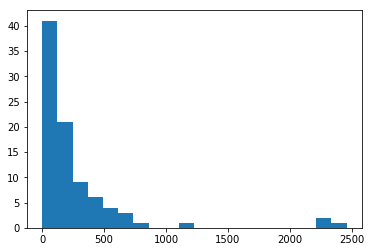

In [15]:
plt.hist(discs_ords['quant_all_discs'], bins=20)

(array([34., 20., 11.,  7., 10.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([  11. ,  135.5,  260. ,  384.5,  509. ,  633.5,  758. ,  882.5,
        1007. , 1131.5, 1256. , 1380.5, 1505. , 1629.5, 1754. , 1878.5,
        2003. , 2127.5, 2252. , 2376.5, 2501. ]),
 <a list of 20 Patch objects>)

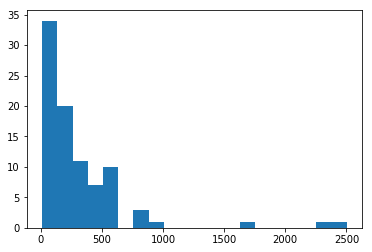

In [16]:
plt.hist(discs_ords['quant_no_disc'], bins=20)

In [ ]:
#Again, the two distributions look very close, both with greatest density around the lower values
#At this point I can predict that there won't be a significant difference between the two

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


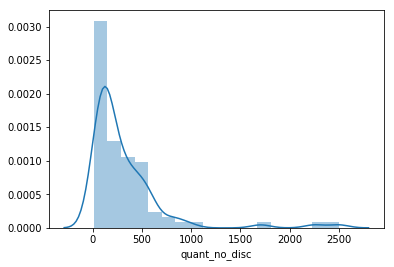

In [18]:
#Show the distribution with a kde to check for normality
sns.distplot(discs_ords['quant_no_disc'])

In [19]:
print("The population distribution has only", discs_ords.shape[0], "values.")

The population distribution has only 89 values.


### Hypothesis 1: Resampling by bootstrapping

In [13]:
#Bootstrap method via https://codingdisciple.com/bootstrap-hypothesis-testing.html
#Get the data to look more "normal" with bootstrapping
#"Control" is the no-discount group
#"Treatment" is the discount group

In [48]:
alpha = 0.05 # The value chosen for comparison with the test statistic.
#Test statistic will need to be lower than this in order to reject the null hypothesis.

In [49]:
p = None #The value chosen for the test statistic. 
#In this case, it will be the number of differences in mean greater than
#or equal to the observed difference in mean between the no-discount dist
# (control group) and the with-discount dist (treatment group.)

In [52]:
#Put the two groups of data into arrays to be resampled &c
control1 = discs_ords['quant_no_disc'] #The quantities of items ordered without discount
treatment1 = discs_ords['quant_all_discs'] #The quantitites of items ordered with a discount

permus = 10000 #number of samples to take

combo = np.concatenate((control1, treatment1), axis = 0) #both dists combined for taking samples

permus_control1 = []
permus_treatment1 = []

for i in range(permus): #Generate this many permutations
    np.random.seed(i) #seed for consistency
    permus_control1.append(resample(combo, n_samples = len(control1)))
    permus_treatment1.append(resample(combo, n_samples = len(treatment1)))
    
#Take the difference in means between the two sets of permutations
diff_boot_means = (np.mean(permus_control1, axis = 1) - np.mean(permus_treatment1, axis = 1))

observed_diff = (np.mean(control1) - np.mean(treatment1))
print('Observed difference between the means:', observed_diff)

Observed difference between the means: 66.07865168539323


In [53]:
#Find the p value by counting how many differences in mean were greater than 
#or equal to the observed difference in means.
means_below_observed = diff_boot_means[diff_boot_means >= observed_diff].shape[0]
p = means_below_observed / permus
print('The p value is.', p)

The p value is. 0.1467


In [54]:
#Get the difference between control and treatment to 
#find the confidence interval
lower_bound = np.percentile(diff_boot_means, 2.5)
upper_bound = np.percentile(diff_boot_means, 97.5)

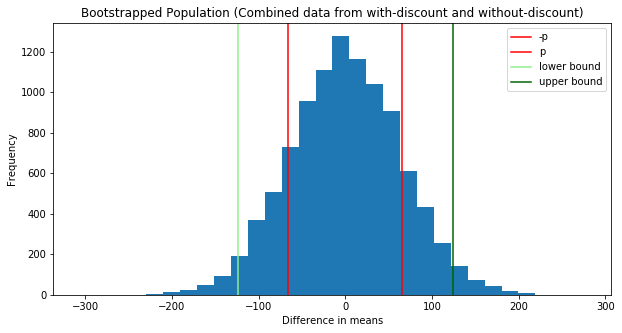

In [55]:
#Plot the differences in means between the 2 bootstrapped groups with the p value
fig = plt.figure(figsize = (10,5))
ax = plt.hist(diff_boot_means, bins = 30)
plt.axvline(-observed_diff, color = 'red', label = '-p')
plt.axvline(observed_diff, color = 'red', label = 'p')
plt.axvline(lower_bound, color = 'lightgreen', label = 'lower bound')
plt.axvline(upper_bound, color = 'darkgreen', label = 'upper bound')
plt.xlabel('Difference in means')
plt.ylabel('Frequency')
plt.legend()
plt.title('Bootstrapped Population (Combined data from with-discount and without-discount)')
plt.show()

In [56]:
#The p-value falls outside of both rejection regions. 
print(means_below_observed, 'out of', permus, 'samples had a difference in means of', 
      round(observed_diff, 2), 'or higher.')

1467 out of 10000 samples had a difference in means of 66.08 or higher.


### Conclusion:

### Hypothesis 1, Part 2: At what level of discount?

In [20]:
disc06 = discs_ords['quant_disc06'] #quantities of items ordered with 06% discount
disc10 = discs_ords['quant_disc10'] #quantities of items ordered with 10% discount
disc15 = discs_ords['quant_disc15'] #quantities of items ordered with 15% discount
disc20 = discs_ords['quant_disc20'] #quantities of items ordered with 20% discount
disc25 = discs_ords['quant_disc25'] #quantities of items ordered with 25% discount

In [21]:
disc_levels = [disc06, disc10, disc15, disc20, disc25]

In [28]:
print(treatment1.mean(), treatment1.sum())
for level in disc_levels:
    print(level.mean(), level.sum(), level[level > 0].shape[0])

255.25842696629215 22718
58.359550561797754 5194 41
49.056179775280896 4366 38
50.06741573033708 4456 38
48.8876404494382 4351 39
48.86516853932584 4349 38


In [29]:
#HISTS TO BE PUT IN LINE LATER
#for level in disc_levels:
#    plt.hist(level, bins=20)
#    plt.show()
#Hists show that these dists are all non-normal too.

In [40]:
#More bootstrapping
#Put the two groups of data into arrays to be resampled &c
permus = 10000 #number of samples to take

combo06 = []
combo10 = []
combo15 = []
combo20 = []
combo25 = []
combos = [combo06, combo10, combo15, combo20, combo25]
discounts = ['.06', '.10', '.15', '.20', '.25']
levels_combos = list(zip(disc_levels, combos, discounts))

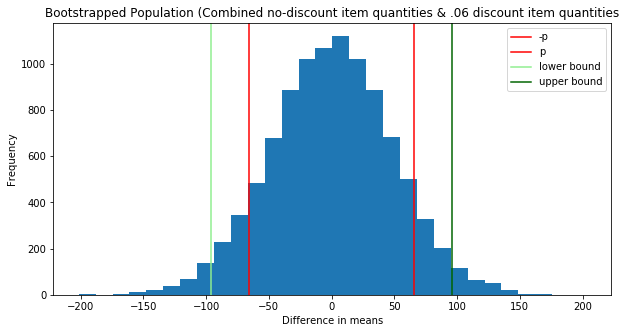

Observed difference between the means: 66.07865168539323
P-value: 0.0857
Lower bound: -95.8202247191011 Upper bound: 96.16348314606732


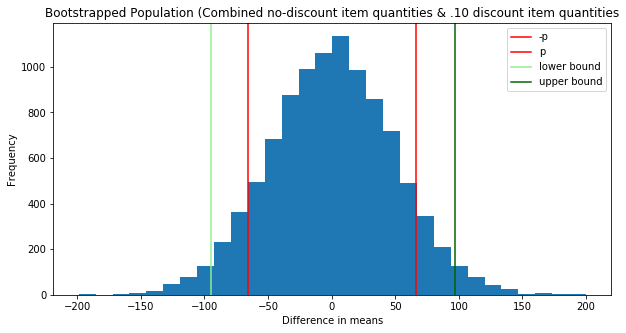

Observed difference between the means: 66.07865168539323
P-value: 0.0862
Lower bound: -94.83258426966292 Upper bound: 97.001404494382


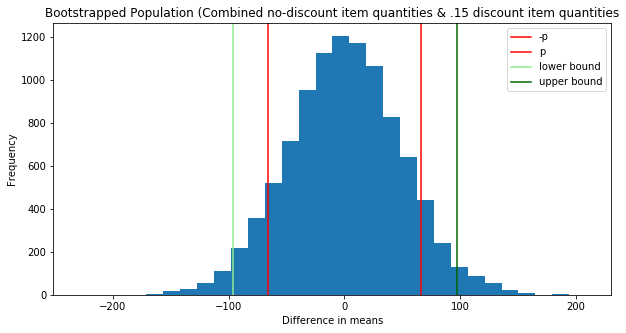

Observed difference between the means: 66.07865168539323
P-value: 0.0879
Lower bound: -96.1137640449438 Upper bound: 96.97780898876404


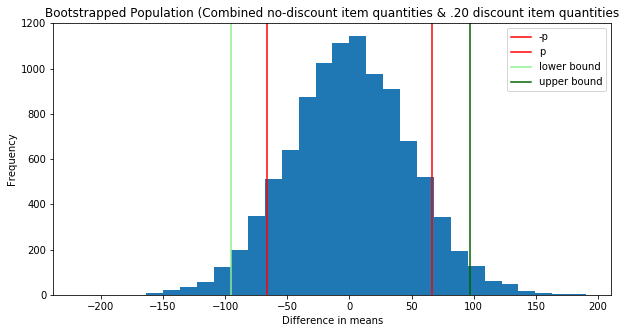

Observed difference between the means: 66.07865168539323
P-value: 0.0867
Lower bound: -95.39353932584267 Upper bound: 96.80898876404494


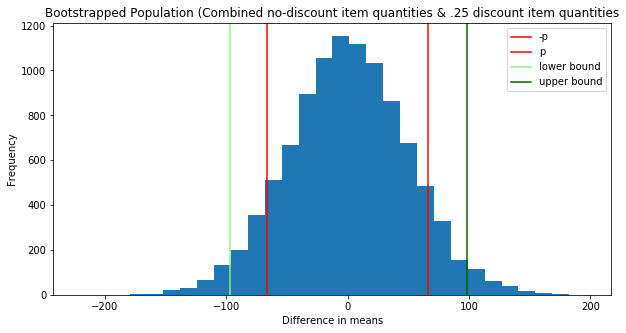

Observed difference between the means: 66.07865168539323
P-value: 0.0879
Lower bound: -96.56264044943818 Upper bound: 98.48398876404494


In [44]:
control = control1

for treatment, combo, discount in levels_combos:
    combo = np.concatenate((control1, treatment), axis = 0) #both dists combined for taking samples

    permus_control = []
    permus_treatment = []

    for i in range(permus): #Generate this many permutations
        np.random.seed(i) #seed for consistency
        permus_control.append(resample(combo, n_samples = len(control)))
        permus_treatment.append(resample(combo, n_samples = len(treatment)))
    
    #Take the difference in means between the two sets of permutations
    diff_boot_means = (np.mean(permus_control, axis = 1) - np.mean(permus_treatment, axis = 1))
    observed_diff = (np.mean(control1) - np.mean(treatment1)) 

    #Find the p value by counting how many differences in mean were greater than 
    #or equal to the observed difference in means.
    means_below_observed = diff_boot_means[diff_boot_means >= observed_diff].shape[0]
    p = means_below_observed / permus

    #Get the difference between control and treatment to 
    #find the confidence interval
    lower_bound = np.percentile(diff_boot_means, 2.5)
    upper_bound = np.percentile(diff_boot_means, 97.5)
    
    #Plot the differences in means between the 2 bootstrapped groups with the p value
    fig = plt.figure(figsize = (10,5))
    ax = plt.hist(diff_boot_means, bins = 30)
    plt.axvline(-observed_diff, color = 'red', label = '-p')
    plt.axvline(observed_diff, color = 'red', label = 'p')
    plt.axvline(lower_bound, color = 'lightgreen', label = 'lower bound')
    plt.axvline(upper_bound, color = 'darkgreen', label = 'upper bound')
    plt.xlabel('Difference in means')
    plt.ylabel('Frequency')
    plt.legend()
    title = 'Bootstrapped Population (Combined no-discount item quantities & ' + discount + ' discount item quantities)'
    plt.title(title)
    plt.show()
    
    #Print summary
    print('Observed difference between the means:', observed_diff)
    print('P-value:', p)
    print('Lower bound:', lower_bound, 'Upper bound:', upper_bound)

In [ ]:
#RESULTS FOR HYPOTHESIS 1 PART 2: Null hypothesis is not rejected

<a id="hypo2"></a>

# Hypothesis 2
[(Back to top)](#top)

Do the employees in the PNW offices get higher invoice totals on average than employees in the London office?

Null hypothesis: average invoice total for London office (Control2) is >= average invoice total for PNW offices (Treatment2)

Alternative hypothesis: average invoice total for London office (Control2) is < average invoice total for PNW office (Treatment2)

An "invoice total" will be the sum of subtotals per order, where each subtotal on an order is unit price * (1 - discount) * quantity.

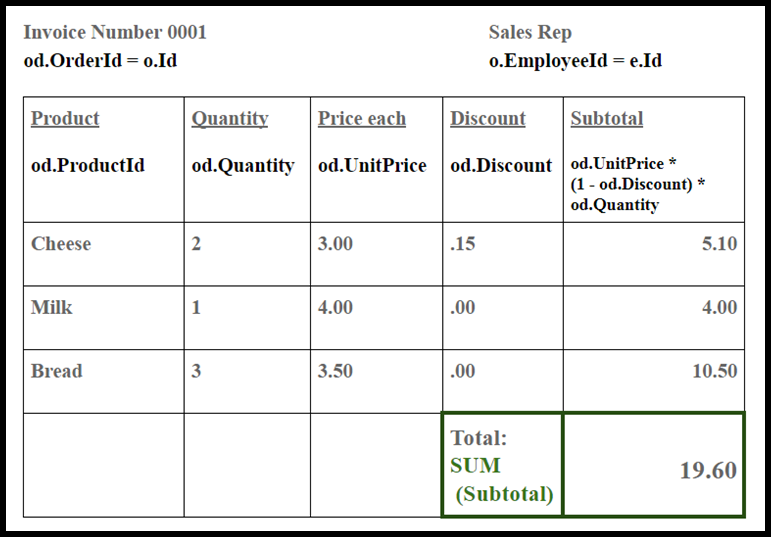

In [98]:
#Get invoice totals for employees in the London office
london_invoices = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City = "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    ''', engine)

#Get invoice totals for employees in the PNW offices
pnw_invoices = pd.read_sql_query('''SELECT od.OrderId, e.City,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City != "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    ''', engine)

2019-02-01 13:42:40,383 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City = "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    


INFO:sqlalchemy.engine.base.Engine:SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City = "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    


2019-02-01 13:42:40,384 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2019-02-01 13:42:40,392 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, e.City,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City != "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    


INFO:sqlalchemy.engine.base.Engine:SELECT od.OrderId, e.City,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City != "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    


2019-02-01 13:42:40,393 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


In [102]:
#A control group from the London invoices
#A treatment group from the PNW invoices
control2 = london_invoices['Invoice_total']
treatment2 = pnw_invoices['Invoice_total']

In [138]:
#Value to compare to p-value
alpha = 0.5

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


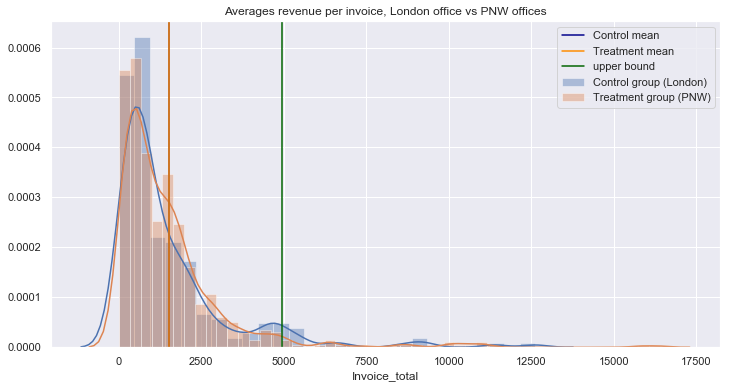

In [137]:
#Plot both distributions
upper_bound = np.percentile(control2, 95)

sns.set(color_codes = True)
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(control2, label = "control group (London)")
sns.distplot(treatment2, label = "treatment group (PNW)")
plt.axvline(control2.mean(), color = 'darkblue', label = 'control mean')
plt.axvline(treatment2.mean(), color = 'darkorange', label = 'treatment mean')
plt.axvline(upper_bound, color = 'darkgreen', label = 'upper bound')
plt.title('Averages revenue per invoice, London office vs PNW offices')
plt.legend()
plt.show()

In [107]:
print('London office invoice mean:', control2.mean())
print('Number of London offices invoices:', len(control2))
print('\n')
print('PNW office invoice mean:', treatment2.mean())
print('Number of PNW office invoices:', len(treatment2))

London office invoice mean: 1538.3112209821427
Number of London offices invoices: 224


PNW office invoice mean: 1520.150702970297
Number of PNW office invoices: 606


In [139]:
t2, p2 = stats.ttest_ind(control2,treatment2)
print('T stat:', t2)
print('P-value:', p2)
if p2 > alpha:
    print('P-value is too high to reject null hypothesis.')

T stat: 0.1257920376990175
P-value: 0.8999270811672762
P-value is too high to reject null hypothesis.


Conclusion: Failure to reject null hypothesis. Average invoice total for London office (Control2) is >= average invoice total for PNW offices (Treatment2)

In [170]:
#How much revenue is generated by each employee?
#Revenue per employee
revenue = pd.read_sql_query('''SELECT e.LastName, e.City,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Revenue
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY e.LastName
                            ORDER BY Revenue DESC
                    ''', engine)
revenue

2019-02-01 16:49:06,444 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, e.City,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Revenue
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY e.LastName
                            ORDER BY Revenue DESC
                    


INFO:sqlalchemy.engine.base.Engine:SELECT e.LastName, e.City,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Revenue
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            GROUP BY e.LastName
                            ORDER BY Revenue DESC
                    


2019-02-01 16:49:06,446 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,LastName,City,Revenue
0,Peacock,Redmond,232890.8460
1,Leverling,Kirkland,202812.8430
2,Davolio,Seattle,192107.6045
3,Fuller,Tacoma,166537.7550
4,Callahan,Seattle,126862.2775
5,King,London,124568.2350
6,Dodsworth,London,77308.0665
7,Suyama,London,73913.1295
8,Buchanan,London,68792.2825


The 4 London employees generate less overall revenue even though their revenue per order is on average not lower than the revenue per order in the PNW offices. In order to match the PNW employees, the London employees can try to fulfill more orders.

<a id="hypo3"></a>

# Hypothesis 3
[(Back to top)](#top)

Did average sales decline in 2014 compared to 2013?

Null hypothesis: Average sales in 2014 (treatment3) were equal to or greater than average sales in 2013 (control3). 

treatment3 >= control3

Alternative hypothesis: Average sales in 2014 (treatment3) were less than average sales in 2013 (control3.)

treatment3 < control3

In [74]:
#Get invoices for 2013
invoices_2013 = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2013%"
                            GROUP BY od.OrderId
                    ''', engine)
#Get invoices for 2013
invoices_2014 = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2014%"
                            GROUP BY od.OrderId
                    ''', engine)

2019-02-01 22:04:50,456 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2013%"
                            GROUP BY od.OrderId
                    


INFO:sqlalchemy.engine.base.Engine:SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2013%"
                            GROUP BY od.OrderId
                    


2019-02-01 22:04:50,458 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2019-02-01 22:04:50,464 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2014%"
                            GROUP BY od.OrderId
                    


INFO:sqlalchemy.engine.base.Engine:SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE o.OrderDate LIKE "2014%"
                            GROUP BY od.OrderId
                    


2019-02-01 22:04:50,465 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


In [78]:
#Control group from 2013 invoices
#Treatment group from 2014 invoices
control3 = invoices_2013['Invoice_total']
treatment3 = invoices_2014['Invoice_total']

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


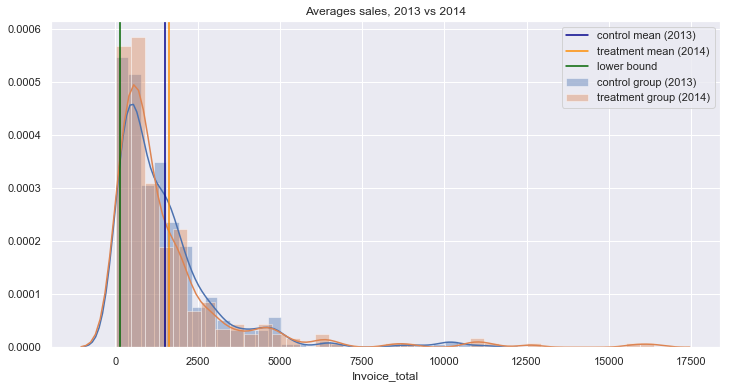

In [83]:
alpha = 0.05
lower_bound = np.percentile(control3, 5)

sns.set(color_codes = True)
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(control3, label = "control group (2013)")
sns.distplot(treatment3, label = "treatment group (2014)")
plt.axvline(control3.mean(), color = 'darkblue', label = 'control mean (2013)')
plt.axvline(treatment3.mean(), color = 'darkorange', label = 'treatment mean (2014)')
plt.axvline(lower_bound, color = 'darkgreen', label = 'lower bound')
plt.title('Averages sales, 2013 vs 2014')
plt.legend()
plt.show()

In [84]:
t3, p3 = stats.ttest_ind(control3, treatment3)
print('T stat:', t3)
print('P-value:', p3)
if p3 > alpha:
    print('P-value is too high to reject null hypothesis.')

T stat: -0.791784376818693
P-value: 0.42876415354731034
P-value is too high to reject null hypothesis.


Conclusion: Failure to reject null hypothesis. Averages sales in 2014 were greater than or equal to average sales in 2013.

In [ ]:
#SANITY CHECK for years of orders
#orders = pd.read_sql_query('''SELECT o.OrderDate, o.RequiredDate, o.ShippedDate
#                                FROM [Order] o
#                               ORDER BY o.OrderDate ASC
#                            ''', engine)
#orders.head()

In [ ]:
# REVENUE PER EMPLOYEE SANITY CHECK
#Working toward revenue per employee
#revenue_test = pd.read_sql_query('''SELECT e.LastName, od.OrderId,
#                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
#                            FROM OrderDetail od
#                            JOIN [Order] o ON od.OrderId = o.Id
#                            JOIN Employee e ON o.EmployeeId = e.Id
#                            GROUP BY od.OrderId
#                            ORDER BY e.LastName
#                    ''', engine)

#proof for revenue per employee via df
#revenue_test[revenue_test['LastName'] == 'Buchanan']['Invoice_total'].sum()
#Buchanan did 68792.2825 in sales

In [ ]:

#HYPO 2 SANITY CHECK CODE


#Working towards getting invoice totals
#df = pd.read_sql_query('''SELECT od.*,
#                            ((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Subtotal
#                            FROM OrderDetail od
#                    ''', engine)

#Get total revenue per invoice (sum of subtotals from all order details per order)
#df = pd.read_sql_query('''SELECT od.OrderId,
#                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
#                            FROM OrderDetail od
#                            GROUP BY od.OrderId
#                    ''', engine)

#Get total revenue per invoice and employee
#df = pd.read_sql_query('''SELECT od.OrderId, e.LastName, e.City,
#                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
#                            FROM OrderDetail od
#                            JOIN [Order] o ON od.OrderId = o.Id
#                            JOIN Employee e ON o.EmployeeId = e.Id
#                            GROUP BY od.OrderId
#                            ORDER BY e.LastName
#                    ''', engine)

In [ ]:
#HYPO 1 PART 1
#Sanity check for quantities
#w/o discount. ALL GOOD
#df_wo_discount = pd.read_sql_query('''SELECT [Order].CustomerId, 
#                                        SUM(
#                                            CASE WHEN OrderDetail.Discount == 0.0
#                                            THEN OrderDetail.Quantity ELSE 0 END
#                                            ) quants_nodisc
#                                        FROM OrderDetail
#                                        INNER JOIN [Order] on OrderDetail.OrderId = [Order].Id
#                                        GROUP BY [Order].CustomerId
#                                        ORDER BY [Order].CustomerId ASC
#                                    ''', engine)

#w/ discount
#df_w_discount = pd.read_sql_query('''SELECT [Order].CustomerId,
#                                        SUM(
#                                            CASE WHEN OrderDetail.Discount != 0.0
#                                            THEN OrderDetail.Quantity ELSE 0 END
#                                            ) quants_disc
#                                        FROM OrderDetail 
#                                        INNER JOIN [Order] on OrderDetail.OrderId = [Order].Id
#                                        WHERE OrderDetail.Discount != 0.0
#                                        GROUP BY [Order].CustomerId
#                                        ORDER BY [Order].CustomerId ASC
#                                ''', engine)

In [ ]:
#HYPO 1 PART 1
#Not sure whether grouping is affecting the quantity sums per order. 
#i.e. is it adding up the quantities for every record assoc with an order id or just for one?
#Look at number of orders per cust id
#alfki = pd.read_sql_query("""SELECT [Order].CustomerId, OrderDetail.*
#                            FROM OrderDetail 
#                            
#                            INNER JOIN [Order] on OrderDetail.OrderId = [Order].Id
#                            WHERE [Order].CustomerId == 'ALFKI'
#                        """, engine)
#PROVEN: sum is of quantities for every record not the group
#alfki['Quantity'].sum()

In [103]:
#FAILED T DIST METHOD TO BE DELETED
#Check for similarity between sampling distribution means
#and population means
control1.mean(), discs_ords['quant_no_disc'].mean()

(320.30266666666665, 321.3370786516854)

In [104]:
treatment1.mean(), discs_ords['quant_all_discs'].mean()

(255.23933333333335, 255.25842696629215)

In [ ]:
#Both are pretty close

In [34]:
diff = control1.mean() - treatment1.mean()
diff

64.24199999999996

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


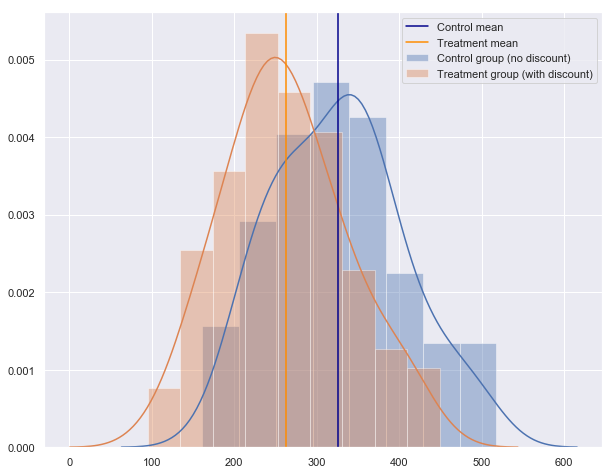

In [90]:
#Compare both sampling distributions with hist and kde
sns.set(color_codes = True)
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(control1, label = "Control group (no discount)")
sns.distplot(treatment1, label = "Treatment group (with discount)")
plt.axvline(control1.mean(), color = 'darkblue', label = 'Control mean')
plt.axvline(treatment1.mean(), color = 'darkorange', label = 'Treatment mean')
plt.legend()
plt.show()

In [28]:
#This plot shows that the mean for the control group is higher.
#The question is, where on the distribution for the control group
#would the value for the mean of the treament group fall? If it is
#outside the critical region in the tails, then it will not be statistically
#significantly different.

In [108]:
control1.mean(), treatment1.mean()

(320.30266666666665, 255.23933333333335)

In [92]:
control1.std(), treatment1.std()

(78.659613988939, 74.82993678706107)

In [55]:
#Calculate a two-sample t statistic
#First get variance of both samples
var = ((control1.std()**2) + (treatment1.std()**2)) / (len(control1) + len(treatment1) - 2)
var

59.5295672345679

In [59]:
control1.std()**2

6187.334872888888

In [62]:
treatment1.std()**2

5599.519439555556

In [78]:
control1_var = sum([(i - np.mean(control1))**2 for i in control1])
control1_var

618733.4872888888

In [79]:
treatment1_var = sum([(i - np.mean(treatment1))**2 for i in treatment1])
treatment1_var

559951.9439555553

In [67]:
#FROM THE LAB ON TWO SAMPLE T TESTS
#def variance(sample):
#    sample_mean = np.mean(sample)
#    return sum([(i - sample_mean)**2 for i in sample])
#def sample_variance(sample1, sample2):
#    n_1, n_2 = len(sample1), len(sample2)
#    var_1, var_2 = variance(sample1), variance(sample2)
#    return (var_1 + var_2)/((n_1 + n_2)-2)

In [80]:
vari = (control1_var + treatment1_var) / (len(control1) + len(treatment1) -2)
vari

5952.9567234567885

In [81]:
#Build numerator for t statistic
numer = np.mean(treatment1) - np.mean(control1)
#Build denominator for t statistic
denom = np.sqrt(vari * ((1/len(treatment1)) + (1/len(control1))))
t = numer / denom
t

-5.887591810766747

In [109]:
test_stat, p_value = stats.ttest_ind(treatment1, control1)
test_stat, p_value

(-5.508644149453619, 1.1153214293532252e-07)

In [111]:
#Another way to find the t value
t_alt = stats.t.ppf(q = 0.975, df = (len(control1) + len(treatment1) -2))
t_alt

1.9720174778338955

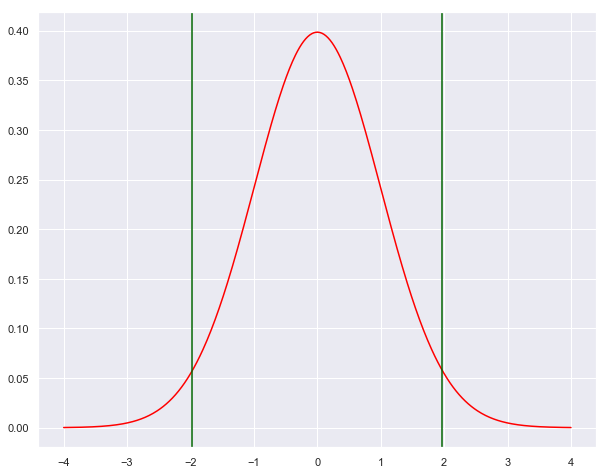

In [106]:
#Draw a t distribution
#A set of points for x
xs = np.linspace(-4, 4, 500)
#A probability density function for the t-dist
ys = stats.t.pdf(xs, (len(control1) + len(treatment1) - 2), 0, 1)

#Draw a figure
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
#t dist in red
ax.plot(xs, ys, color = 'red')
#critical region
ax.axvline(t_alt, color = 'darkgreen')
#other critical region
ax.axvline(-t_alt, color = 'darkgreen')
plt.show()

In [85]:
stats.t.sf(abs(t), len(control1) + len(treatment1) - 1) * 2

1.64338928498428e-08

In [10]:
#MORE BOOTSTRAPPING CODE FOR HYPO 1. FINDS THE CONFIDENCE INTERVALS
#NOT NEEDED FOR HYPO 1, SAVE FOR LATER
#control1_boot = [] #10,000 permutations with replacement 
#for i in range(permus):
#    np.random.seed(i)
#    control1_boot.append((resample(control1)))

#control1_boot = np.mean(control1_boot, axis = 1)
#control1_boot #10,000 means

#treatment1_boot = [] #10,000 permutations with replacement 
#for i in range(permus):
#    np.random.seed(i)
#    treatment1_boot.append((resample(treatment1)))

#treatment1_boot = np.mean(treatment1_boot, axis = 1)
#treatment1_boot #10,000 means

#Get the difference between control and treatment to 
#find the confidence interval
#diffs = control1_boot - treatment1_boot
#lower_bound = np.percentile(diffs, 2.5)
#upper_bound = np.percentile(diffs, 97.5)

#Plot the confidence interval
#fig = plt.figure(figsize=(10,3))
#ax = plt.hist(diffs, bins=30)

#plt.xlabel('Differences between quantities of items ordered, no-discount vs with-discount')
#plt.ylabel('Frequency')
#plt.axvline(lower_bound, color = 'green')
#plt.axvline(upper_bound, color = 'green')
#plt.axvline(66.07, color = 'red') #true difference in means
#plt.title('Bootstrapped Pop (Differences Between 2 Control 1 & Treatment 1)')
#plt.show()

#print('95% confidence that true difference between control and treatment groups is between', 
#      round(lower_bound, 2), 'and', round(upper_bound, 2), ', assuming null hypothesis is correct.')

#mu1 = discs_ords['quant_no_disc'].mean() - discs_ords['quant_all_discs'].mean()
#print('The true difference in means for control 1 and treatment 1 is', mu1)

In [ ]:
####EDA
#Look at how many customers each company has
df = pd.read_sql_query("""SELECT Customer.Id, Customer.CompanyName
                            FROM Customer
                            ORDER BY Customer.CompanyName
                        """, engine)

In [ ]:
#Every company has only one customer. Orders can therefore be counted by customer or by company.
sum(df['CompanyName'].value_counts() > 1)

In [ ]:
# JUST AN EXAMPLE from the labs
#"""SELECT o.ID, c.CompanyName, Count(*) num_orders 
#    FROM [Order] o
#    INNER JOIN Customer c on o.CustomerID = c.ID 
#    GROUP BY c.CompanyName 
#    ORDER BY num_orders DESC"""

#df = pd.read_sql_query("""SELECT o.ID, c.CompanyName, Count(*) num_orders FROM [Order] \
#o INNER JOIN Customer c on o.CustomerID = c.ID GROUP BY c.CompanyName ORDER BY num_orders DESC""", engine)
#df.head()